In [6]:
%load_ext autoreload
%autoreload 2
from kernel import KernelLogisticRegression
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

## Introduction

## Part A: Implementation

In [1]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y

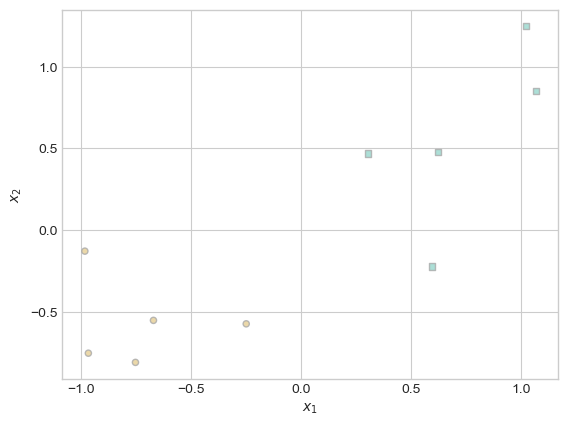

In [28]:
def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 10, noise = 0.4)
plot_classification_data(X, y, ax)

In [32]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 0.1)
KR.fit(X, y, m_epochs = 1000, lr = 0.0001)

torch.Size([10])
torch.Size([10])


RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 0

NameError: name 'plt' is not defined

## Part B: Experiments